In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
data = pd.read_csv("/content/Reddit_Data.csv")
print(data.head())
#1 - Positive
#0 - Neutral
#-1 - Negative

                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1


In [6]:
print(len(data.columns))
#2, => X : col cu comm,   Y:col cu category(desired to be pred.)
print(data.shape[0])

2
37249


In [4]:
data.isnull().sum()


clean_comment    100
category           0
dtype: int64

In [7]:
data = data.dropna()
#for sentiment analysis, the null values does not affect the data, but here I will remove rows that contain 0 

In [8]:
data.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [9]:
print(data.describe())

           category
count  37149.000000
mean       0.203316
std        0.779491
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [17]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["clean_comment"] = data["clean_comment"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


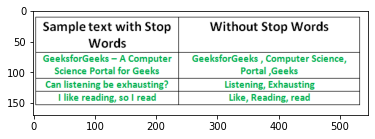

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/Stop-word-removal-using-NLTK.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
#this is how it should look after removing stopwords

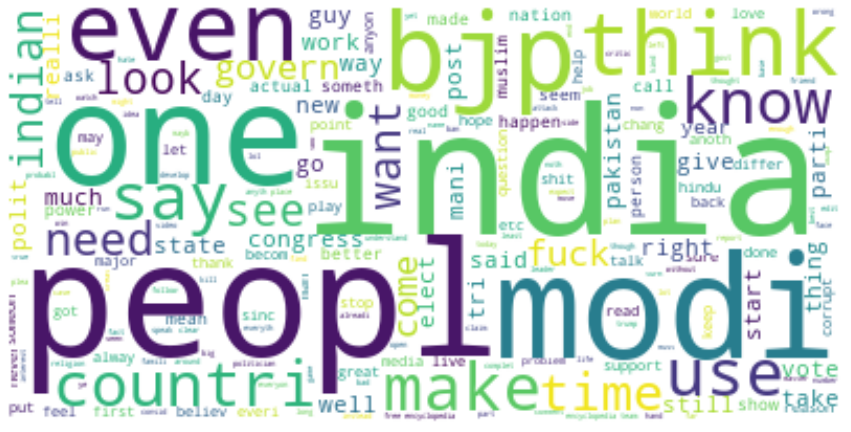

In [19]:
clean_comment = " ".join(i for i in data.clean_comment)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(clean_comment)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
data.shape

(37149, 2)

In [21]:
def transform_category(category):
    if category == -1:
        return "negative"
    if category == 0:
        return "neutral"
    if category == 1:
        return "positive"

data['category'] = data['category'].apply(lambda category: transform_category(category))

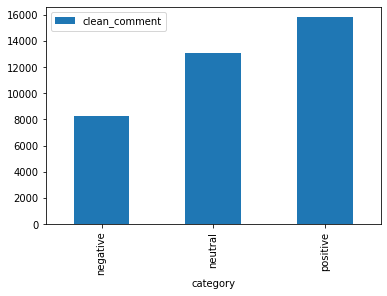

In [22]:
data.groupby('category').count().plot(kind='bar')

category = pd.get_dummies(data.category)
data_category = pd.concat([data, category], axis=1)
data_category = data_category.drop(columns='category')
data_category.head()

text = data_category['clean_comment'].astype(str)
label = data_category[['negative', 'neutral', 'positive']].values



In [27]:

import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

score_train, score_test, label_train, label_test = train_test_split(text, label, test_size = 0.2) 



In [28]:
tokenizer = Tokenizer(num_words=2500, oov_token='x')
tokenizer.fit_on_texts(score_train) 
tokenizer.fit_on_texts(score_test)
 
sekuens_train = tokenizer.texts_to_sequences(score_train)
sekuens_test = tokenizer.texts_to_sequences(score_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [29]:
model = Sequential([                       
    Embedding(input_dim=2500, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          40000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 69,443
Trainable params: 69,443
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs = 10
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2)

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
# acc (train-val)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss (train-val)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()